In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import math
import random

In [11]:
# --- Hyperparameters (as used in training) ---
batch_size = 128
patch_size = 16
embed_dim = 64
num_heads = 4
num_layers = 3
num_classes = 10
img_size = 256
seq_len = 11
data_path = "./data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def stitch_and_resize(images, labels, out_size=img_size):
    """
    images: Tensor of shape (N, 1, 28, 28)
    labels: Tensor of N integers representing the labels of the images
    Returns: Tensor of shape (1, out_size, out_size) and a tensor of labels of shape (N,)
    """
    # Squeeze channel for concatenation
    images = images.squeeze(1)  # (N, 28, 28)
    # Extract the label from each image and append in order of image selection
    labels = torch.tensor(labels)  # (N,)
    N = len(images)
    grid_size = math.ceil(math.sqrt(N))
    pad_needed = grid_size**2 - N
    if pad_needed > 0:
        blank = torch.zeros((28, 28), dtype=images.dtype, device=images.device)
        # Add pad_needed blank images to fill the grid
        images = torch.cat([images, blank.unsqueeze(0).repeat(pad_needed, 1, 1)], dim=0)

    rows = []
    for r in range(grid_size):
        row_imgs = images[r*grid_size:(r+1)*grid_size]  # shape: (cols, 28, 28)
        row_cat = torch.cat(list(row_imgs), dim=1)      # concat horizontally
        rows.append(row_cat)
    
    # Concatenate all rows vertically
    stitched = torch.cat(rows, dim=0).unsqueeze(0)   # vertical, shape: (1, H, W)

    # Now resize to (1, out_size, out_size)
    stitched_resized = TF.resize(stitched, [out_size, out_size])
    return stitched_resized, labels

# --- Custom Dataset ---
class CustomMNISTDataset(torch.utils.data.Dataset):
    """ Custom Dataset for MNIST that stitches a given number of images together """
    def __init__(self, mnist_dataset, length=60000):
        self.mnist_dataset = mnist_dataset
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Get N random images and their labels
        num = torch.randint(1, 11, (1,)).item()  # Randomly choose between 1 and 10
        idxs = torch.randint(0, len(self.mnist_dataset), (num,)) # Random indices
        # Get images and labels from the dataset
        imgs, labels = zip(*(self.mnist_dataset[i.item()] for i in idxs))
        labels = list(labels) + [11]
        images = torch.stack(imgs)
        stitched_image, stitched_label = stitch_and_resize(images, labels)
        return stitched_image, stitched_label

# --- Patch Embedding ---
class PatchEmbed(nn.Module):
    """ Patch Embedding Layer for Vision Transformer
    Args:"""
    def __init__(self, patch_size=patch_size, embed_dim=embed_dim, img_size=img_size, in_chans=1):
        super().__init__()
        num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = num_patches
        self.proj = nn.Linear(patch_size * patch_size * in_chans, embed_dim)

    def forward(self, x):
        # x: (B, 1, 256, 256)
        B, C, H, W = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        # patches: (B, C, num_patches_h, num_patches_w, patch_size, patch_size)
        patches = patches.contiguous().view(B, C, -1, self.patch_size, self.patch_size)
        # patches: (B, C, num_patches, patch_size, patch_size)
        patches = patches.permute(0, 2, 1, 3, 4)  # (B, num_patches, C, 16, 16)
        patches = patches.reshape(B, self.num_patches, -1)  # (B, num_patches, patch_size*patch_size*C) / (B, 256, 256)
        return self.proj(patches)  # (B, 256, embed_dim)
    
# --- Encoder Block ---
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )

    def forward(self, x):
        x_res1 = x
        x = self.ln1(x)
        x, _ = self.attn(x, x, x)
        x = x + x_res1

        x_res2 = x
        x = self.ln2(x)
        x = self.mlp(x)
        x = x + x_res2
        return x

# --- Decoder Block ---
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.masked_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ln3 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )

    def forward(self, x, enc_out, mask):
        x_res1 = x
        x = self.ln1(x)
        x, _ = self.masked_attn(x, x, x, attn_mask=mask)
        x = x + x_res1

        x_res2 = x
        x, _ = self.cross_attn(x, enc_out, enc_out)

        x = self.ln2(x)
        x = x + x_res2

        x_res3 = x
        x = self.mlp(x)
        x = x + x_res3
        return x
    
# --- Visual Transformer ---
class VisualTransformer(nn.Module):
    def __init__(self, patch_size, embed_dim, num_heads, num_layers, num_classes, img_size=img_size, in_chans=1, seq_len=11):
        super().__init__()
        self.patch_embed = PatchEmbed(patch_size, embed_dim, img_size, in_chans)
        num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.pos_encod_enc = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_encod_enc, std=0.02)

        self.encoder = nn.ModuleList([EncoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self.seq_len = seq_len
        self.vocab_size = num_classes + 3   # +1 for start token
        self.tok_embed = nn.Embedding(self.vocab_size, embed_dim)
        self.pos_encod_dec = nn.Parameter(torch.zeros(1, seq_len, embed_dim))
        nn.init.trunc_normal_(self.pos_encod_dec, std=0.02)

        self.decoder = nn.ModuleList([DecoderBlock(embed_dim, num_heads) for _ in range(num_layers)])
        self.linear = nn.Linear(embed_dim, self.vocab_size)


    def forward(self, x, y):
        # x: (B, 1, 256, 256)
        B = x.shape[0]
        x = self.patch_embed(x)                        # (B, 256, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)          # (B, 257, embed_dim)
        x = x + self.pos_encod_enc                     # (B, 257, embed_dim)
        for block in self.encoder:
            x = block(x)
        x = self.norm(x)                               # (B, 257, embed_dim)

        # y: (B, seq_len)
        y = self.tok_embed(y)                                 # (B, seq_len, embed_dim)
        curr_seq_len = y.shape[1]
        pos_encod_dec = self.pos_encod_dec[:, :curr_seq_len, :].expand(B, curr_seq_len, -1)
        y = y + pos_encod_dec                           # (B, seq_len, embed_dim)
        mask = torch.triu(torch.ones((curr_seq_len, curr_seq_len), device=x.device), diagonal=1).bool()
        for block in self.decoder:
            y = block(y, x, mask=mask)      # (B, seq_len, embed_dim)
        out = self.linear(y)                # (B, seq_len, vocab_size)
        return out
    
def collate_fn(batch):
    x_seqs, y_seqs = zip(*batch)
    y_lens = [y.shape[0] for y in y_seqs]
    x_batch = torch.stack(x_seqs)
    y_padded = pad_sequence(y_seqs, batch_first=True, padding_value=12)
    return x_batch, y_padded, y_lens

In [12]:
# --- Prepare Test Data ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_test = datasets.MNIST(root=data_path, train=False, download=False, transform=transform)
test_dataset_stitch = CustomMNISTDataset(mnist_test, length=5000)  # Use a subset for faster eval if you wish
test_loader_stitch = DataLoader(test_dataset_stitch, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [13]:
# --- Load Model ---
model = VisualTransformer(
    patch_size=patch_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,
    img_size=img_size,
    seq_len=seq_len
).to(device)
model.load_state_dict(torch.load('mnist_vit_multi_stitch.pth', map_location=device))
model.eval()

VisualTransformer(
  (patch_embed): PatchEmbed(
    (proj): Linear(in_features=256, out_features=64, bias=True)
  )
  (encoder): ModuleList(
    (0-2): 3 x EncoderBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=256, out_features=64, bias=True)
      )
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=64, out_features=10, bias=True)
  (tok_embed): Embedding(13, 64)
  (decoder): ModuleList(
    (0-2): 3 x DecoderBlock(
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (masked_attn): MultiheadAttention(
        (out_proj): NonDynamica

Ground Truth: 34105
Prediction :  34105
Ground Truth: 7921436
Prediction :  7921436
Ground Truth: 6127260540
Prediction :  6127260540
Ground Truth: 967
Prediction :  967


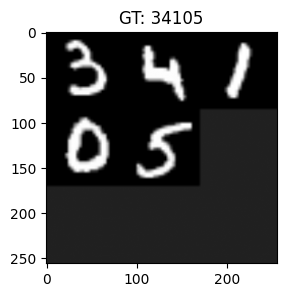

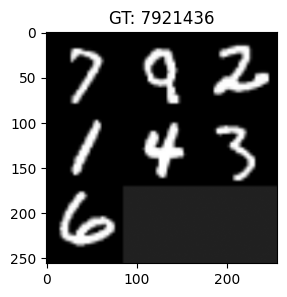

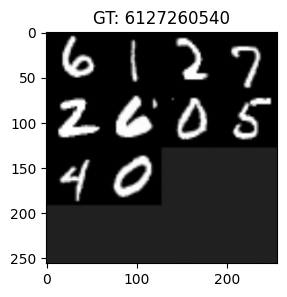

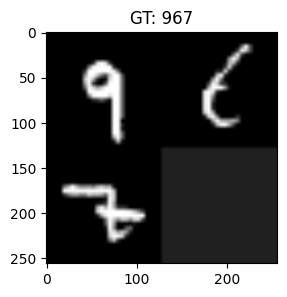

In [14]:
# --- Plot and Predict on First Few Test Samples ---
pad_token = 12
eos_token = 11
start_token = 10

for i in range(4):
    stitched_img, label_tensor = test_dataset_stitch[i]
    plt.figure(figsize=(3,3))
    plt.imshow(stitched_img.squeeze().cpu().numpy(), cmap="gray")
    # Display ground truth (exclude EOS, PAD)
    gt_digits = [d.item() for d in label_tensor if d.item() not in [eos_token, pad_token]]
    plt.title(f"GT: {''.join(str(d) for d in gt_digits)}")

    # --- Run model inference (greedy decoding) ---
    with torch.no_grad():
        x = stitched_img.unsqueeze(0).to(device)
        y_input = torch.full((1, 1), start_token, dtype=torch.long, device=device)
        preds = []
        for t in range(seq_len):
            out = model(x, y_input)
            next_token = out[0, -1].argmax().item()
            preds.append(next_token)
            if next_token == eos_token:
                break
            y_input = torch.cat([y_input, torch.tensor([[next_token]], device=device)], dim=1)
    pred_digits = [d for d in preds if d not in [start_token, eos_token, pad_token]]
    print(f"Ground Truth: {''.join(str(d) for d in gt_digits)}")
    print(f"Prediction :  {''.join(str(d) for d in pred_digits)}")

In [ ]:
# --- Full Test Set Evaluation (Token & Seq Accuracy) ---
def evaluate(model, data_loader):
    model.eval()
    correct_tokens, total_tokens = 0, 0
    correct_seqs, total_seqs = 0, 0
    pad_token = 12
    eos_token = 11
    start_token = 10

    with torch.no_grad():
        for x, y, y_lens in data_loader:
            x, y = x.to(device), y.to(device)
            B, seq_len = y.shape
            # Greedy decode with start token
            y_input = torch.full((B, 1), start_token, dtype=torch.long, device=device)
            preds = []
            for t in range(seq_len):
                out = model(x, y_input)
                next_token = out[:, -1, :].argmax(dim=-1, keepdim=True)
                preds.append(next_token)
                y_input = torch.cat([y_input, next_token], dim=1)
            preds = torch.cat(preds, dim=1)  # (B, seq_len)

            # Per-token accuracy
            mask = (y != pad_token)
            correct_tokens += (preds[mask] == y[mask]).sum().item()
            total_tokens += mask.sum().item()
            # Per-sequence accuracy (up to EOS or PAD)
            for i in range(B):
                gt_seq = []
                for tok in y[i].tolist():
                    if tok == eos_token or tok == pad_token:
                        break
                    gt_seq.append(tok)
                pred_seq = []
                for tok in preds[i].tolist():
                    if tok == eos_token or tok == pad_token:
                        break
                    pred_seq.append(tok)
                if pred_seq == gt_seq:
                    correct_seqs += 1
                total_seqs += 1
    token_acc = 100 * correct_tokens / total_tokens if total_tokens else 0
    seq_acc = 100 * correct_seqs / total_seqs if total_seqs else 0
    print(f"Token Accuracy: {token_acc:.2f}% | Sequence Accuracy: {seq_acc:.2f}%")
    return token_acc, seq_acc

# Evaluate on test set
evaluate(model, test_loader_stitch)